In [1]:
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_wap_lead6_regressor(
        dataset: pd.DataFrame,
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'wap', 'wap_lead6', 'index_wap']
    feature_columns = [
        'stock_id',
        'seconds_in_bucket',
        'imbalance_size',
        'imbalance_buy_sell_flag',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_bid_price',
        'sum_ask_bid_price',
        'diff_ask_bid_size',
        'sum_ask_bid_size',
        'diff_far_near_price',
        'sum_far_near_price'
    ]

    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    train_time = time[-46*3:-46*2]
    valid_time = time[-46*2:-46]
    test_time = time[-46:]
    print(train_time)
    print(valid_time)
    print(test_time)
    print(train_time.shape, np.min(train_time), np.max(train_time))
    print(valid_time.shape, np.min(valid_time), np.max(valid_time))
    print(test_time.shape, np.min(test_time), np.max(test_time))

    plot_time(time, train_time, valid_time, test_time)
    
    train_X = dataset.query('date_id in @train_time')[feature_columns].reset_index(drop=True)
    train_y = dataset.query('date_id in @train_time')[target_columns].reset_index(drop=True)
    valid_X = dataset.query('date_id in @valid_time')[feature_columns].reset_index(drop=True)
    valid_y = dataset.query('date_id in @valid_time')[target_columns].reset_index(drop=True)
    test_X = dataset.query('date_id in @test_time')[feature_columns].reset_index(drop=True)
    test_y = dataset.query('date_id in @test_time')[target_columns].reset_index(drop=True)
    print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
    print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
    print(f'test_X.shape : {test_X.shape},  test_y.shape : {test_y.shape}')
    
    objective = Objective(train_X, train_y['wap_lead6'], valid_X, valid_y['wap_lead6'])
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=5)
    best_params = study.best_params
    add_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'mae',
        'metric': 'mae',
        'seed': 42,
    }
    best_params.update(add_params)

    [print(f'{k}: {v}') for k, v in best_params.items()]
    print(f'best value: {study.best_value}')

    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(100),
    ]
    
    train_dataset = lgb.Dataset(train_X, train_y['wap_lead6'])
    valid_dataset = lgb.Dataset(valid_X, valid_y['wap_lead6'])
    
    model = lgb.train(
        params=best_params,
        train_set=train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        valid_names=['train', 'valid'],
        callbacks=callbacks,
        num_boost_round=3000,
    )
    model.save_model(
        outputs_dir.joinpath(f'lightgbm_optuna'),
        num_iteration=model.best_iteration
    )

    fimp = model.feature_importance(importance_type='gain')
    fimp = pd.DataFrame(fimp, index=feature_columns, columns=['feature_importance'])
    fimp.sort_values('feature_importance', inplace=True)
    display(fimp)
    
    fimp.plot(kind='barh')
    plt.show()
    
    train_y['regression'] = pd.DataFrame(model.predict(train_X, num_iteration=model.best_iteration))
    valid_y['regression'] = pd.DataFrame(model.predict(valid_X, num_iteration=model.best_iteration))
    test_y['regression'] = pd.DataFrame(model.predict(test_X, num_iteration=model.best_iteration))
    
    print(f'train mae: {np.mean(abs(train_y["wap_lead6"] - train_y["regression"]))}')
    print(f'valid mae: {np.mean(abs(valid_y["wap_lead6"] - valid_y["regression"]))}')
    print(f'test mae: {np.mean(abs(test_y["wap_lead6"] - test_y["regression"]))}')

    _, ax = plt.subplots()
    _, bins, _ = ax.hist(valid_y['wap_lead6'], bins=100, histtype='step', label='truth')
    ax.hist(valid_y['regression'], bins=bins, histtype='step', label='regression')
    ax.legend()
    plt.show()
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param': best_params,
                'best_value': study.best_value,
                'valid mae': np.mean(abs(valid_y['wap_lead6'] - valid_y['regression'])),
                'test mae': np.mean(abs(test_y['wap_lead6'] - test_y['regression'])),
            },
            f,
            default_flow_style=False
        )
    return test_y, model


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            #'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )

        preds = model.predict(self.valid_X, num_iteration=model.best_iteration)
        mae = np.mean(abs(preds - self.valid_y))
        return mae
    

def plot_time(all_time, train_time, valid_time, test_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid', height=0.6, width=[len(train_time), len(valid_time), len(test_time)],
            left=[train_time.min(), valid_time.min(), test_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2, test_time.min()+len(test_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [len(all_time), len(train_time), len(valid_time), len(test_time)]
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.max(), test_time.max(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

In [3]:
def preprocess(df):
    df.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df.eval('diff_far_near_price = far_price - near_price', inplace=True)
    df.eval('sum_far_near_price = far_price + near_price', inplace=True)
    df['wap_lead6'] = df.groupby(['stock_id', 'date_id'])['wap'].shift(-6)
    df.dropna(
        axis=0,
        subset=['wap_lead6'],
        inplace=True,
    )

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size,diff_far_near_price,sum_far_near_price,wap_lead6
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,...,-3.029704,0,0_0_0,0.000214,1.999838,-52158.47,69144.53,NaN,NaN,1.000517
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,...,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13,NaN,NaN,1.000268
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,...,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00,NaN,NaN,0.999981
3,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,...,-4.010200,0,0_0_3,0.000215,2.000213,476707.50,481357.30,NaN,NaN,1.000419
4,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,...,-7.349849,0,0_0_4,0.000622,1.999410,-16051.44,16919.64,NaN,NaN,1.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236775,195,480,480,3202296.36,0,1.000551,27733195.21,0.999734,0.999734,1.000551,...,-1.389980,26448,480_480_195,0.000116,2.001218,41110.09,80754.31,0.000000,1.999468,1.000328
5236776,196,480,480,374092.11,0,1.000643,9163117.47,1.000129,1.000129,1.000643,...,1.319647,26448,480_480_196,0.000257,2.001543,-39291.33,178427.15,0.000000,2.000258,1.000819
5236777,197,480,480,1109455.00,0,0.996164,12559273.97,0.995789,0.995883,0.996164,...,-3.259778,26448,480_480_197,0.000374,1.992702,145290.10,230338.10,-0.000094,1.991672,0.995797
5236778,198,480,480,0.00,1,0.999210,94279238.45,0.999210,0.999210,0.999210,...,-2.020001,26448,480_480_198,0.000241,1.998661,59240.07,792296.07,0.000000,1.998420,0.999008


Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'diff_ask_bid_price',
       'sum_ask_bid_price', 'diff_ask_bid_size', 'sum_ask_bid_size',
       'diff_far_near_price', 'sum_far_near_price', 'wap_lead6'],
      dtype='object')


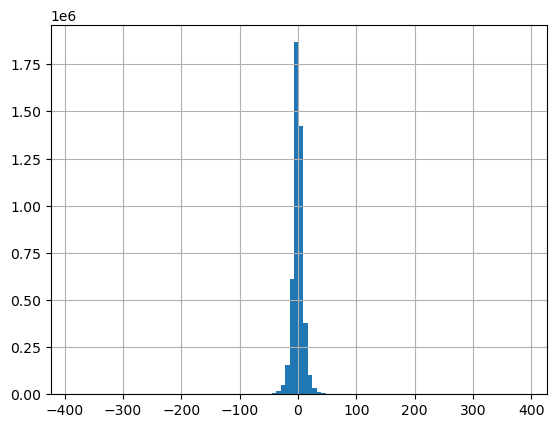

In [4]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path.joinpath('train.csv'))
train_df = train_df.dropna(subset=['target'])
preprocess(train_df)
display(train_df)
print(train_df.columns)

train_df['target'].hist(bins=100)
plt.show()

In [5]:
train_df['index_wap'] = train_df['wap_lead6'] / train_df['wap'] - train_df['target'] / 10000
train_df['index_wap'] = train_df['index_wap'].round(5)
train_df['mean_wap'] = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])['wap']
    .transform('mean')
)
train_df['mean_wap_lead6'] = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])['wap_lead6']
    .transform('mean')
)
train_df['mean_wap_lead6_div_mean_wap'] = train_df['mean_wap_lead6'] / train_df['mean_wap']
r = np.corrcoef(train_df["mean_wap_lead6_div_mean_wap"], train_df["index_wap"])[0, 1]
print(f'correlation coefficient: {r:.4f}')

display(train_df[
    ['stock_id', 'date_id', 'bid_size', 'ask_size',
     'wap', 'wap_lead6', 'mean_wap', 'mean_wap_lead6',
     'index_wap', 'mean_wap_lead6_div_mean_wap', 'target']
])

correlation coefficient: 0.9857


,stock_id,date_id,bid_size,ask_size,wap,wap_lead6,mean_wap,mean_wap_lead6,index_wap,mean_wap_lead6_div_mean_wap,target
0,0,0,60651.50,8493.03,1.000000,1.000517,1.00000,1.000756,1.00082,1.000756,-3.029704
1,1,0,3233.04,20605.09,1.000000,1.000268,1.00000,1.000756,1.00082,1.000756,-5.519986
2,2,0,37956.00,18995.00,1.000000,0.999981,1.00000,1.000756,1.00082,1.000756,-8.389950
3,3,0,2324.90,479032.40,1.000000,1.000419,1.00000,1.000756,1.00082,1.000756,-4.010200
4,4,0,16485.54,434.10,1.000000,1.000086,1.00000,1.000756,1.00082,1.000756,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...
5236775,195,480,19822.11,60932.20,1.000579,1.000328,0.99917,0.999098,0.99989,0.999928,-1.389980
5236776,196,480,108859.24,69567.91,1.000800,1.000819,0.99917,0.999098,0.99989,0.999928,1.319647
5236777,197,480,42524.00,187814.10,0.996233,0.995797,0.99917,0.999098,0.99989,0.999928,-3.259778
5236778,198,480,366528.00,425768.07,0.999322,0.999008,0.99917,0.999098,0.99989,0.999928,-2.020001


[342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387]
[388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405
 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433]
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479]
(46,) 342 387
(46,) 388 433
(46,) 434 479


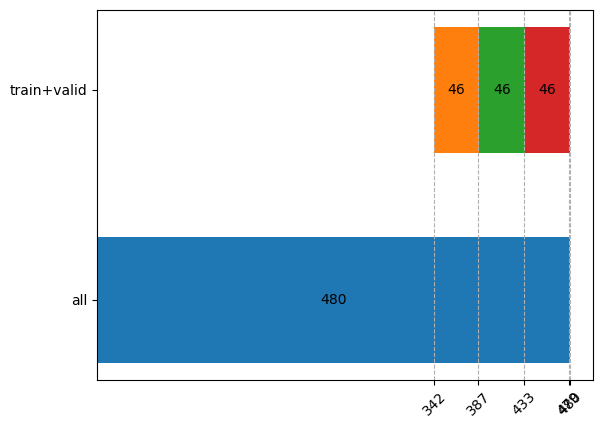

[I 2023-11-10 23:03:39,215] A new study created in memory with name: no-name-8c07976c-8a73-4d37-8d3b-8bf6bbc98e79


train_X.shape: (450800, 19), train_y.shape: (450800, 7)
valid_X.shape: (450751, 19), valid_y.shape: (450751, 7)
test_X.shape : (450751, 19),  test_y.shape : (450751, 7)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	train's l1: 0.00073165	valid's l1: 0.000726668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	train's l1: 0.000728711	valid's l1: 0.000727149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[975]	train's l1: 0.000733593	valid's l1: 0.000726484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1269]	train's l1: 0.000731546	valid's l1: 0.000726542
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	train's l1: 0.000732647	valid's l1: 0.000726666
learning_rate: 0.016445845403801215
max_depth: 4
task: train
boosting_type: 

,feature_importance
sum_ask_bid_size,3.584355e+03
far_price,9.035658e+03
sum_far_near_price,9.472894e+03
stock_id,1.104284e+04
bid_size,1.446078e+04
imbalance_buy_sell_flag,1.599423e+04
diff_far_near_price,1.621423e+04
ask_size,1.792009e+04
imbalance_size,2.416495e+04
diff_ask_bid_size,3.425070e+04


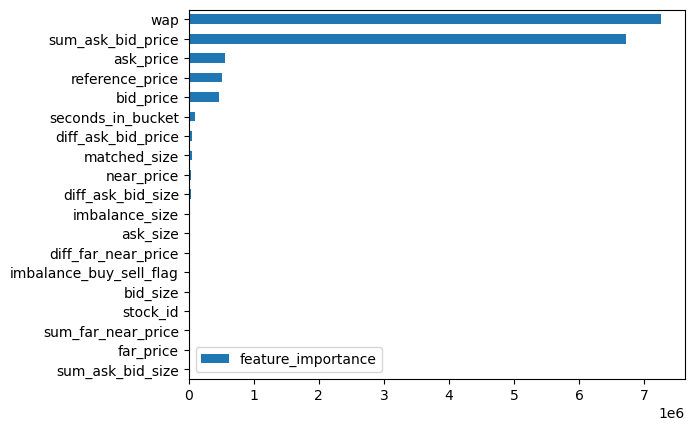

train mae: 0.0007335927764210631
valid mae: 0.0007264838662473777
test mae: 0.0006807933104619277


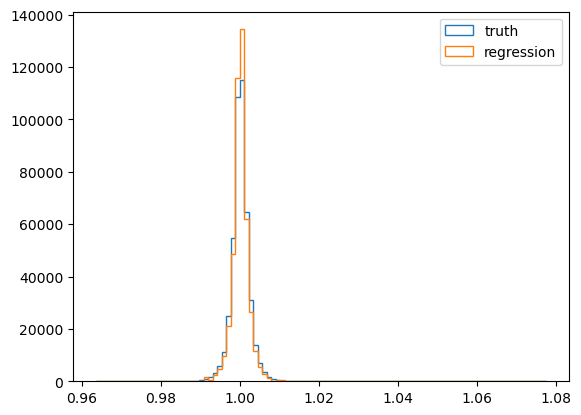

,stock_id,date_id,seconds_in_bucket,target,wap,wap_lead6,index_wap,regression
0,0,434,0,-1.440048,1.000000,1.000011,1.00016,1.000133
1,1,434,0,7.760525,1.000000,1.000931,1.00015,1.000796
2,2,434,0,0.840426,1.000000,1.000239,1.00015,1.000097
3,3,434,0,12.819767,1.000000,1.001437,1.00016,1.000100
4,4,434,0,-13.949871,1.000000,0.998760,1.00015,1.000078
...,...,...,...,...,...,...,...,...
450746,195,479,480,-0.830293,0.999536,0.999162,0.99971,0.999518
450747,196,479,480,-1.689792,1.000123,0.999663,0.99971,1.000084
450748,197,479,480,6.749630,1.000172,1.000555,0.99971,1.000174
450749,198,479,480,3.650188,0.996835,0.996908,0.99971,0.996931


In [6]:
result, model = train_wap_lead6_regressor(
    dataset=train_df,
    outputs_dir=outputs_dir_path, 
)
display(result)

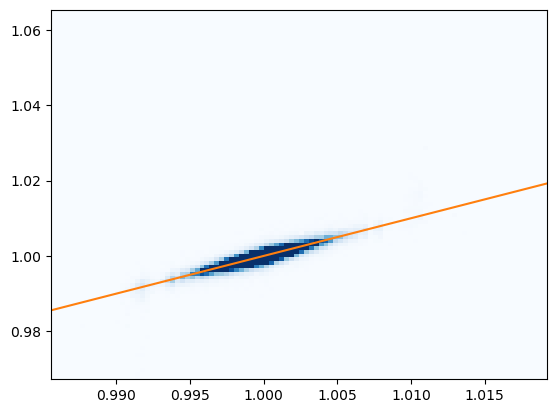

0.8849016153046856


In [7]:
_, ax = plt.subplots()
ax.hist2d(result['regression'], result['wap_lead6'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([0, 10], [0, 10], color='tab:orange')
plt.show()

r = np.corrcoef(result['regression'], result['wap_lead6'])
print(r[0, 1])

In [10]:
result['mean_wap'] = (
    result
    .groupby(['date_id', 'seconds_in_bucket'])['wap']
    .transform('mean')
)
result['mean_regression'] = (
    result
    .groupby(['date_id', 'seconds_in_bucket'])['regression']
    .transform('mean')
)
result['calculated_target'] = (result['regression'] / result['wap'] - result['mean_regression'] / result['mean_wap']) * 10000
display(result)
display(result.isna().sum())
result.dropna(inplace=True)

,stock_id,date_id,seconds_in_bucket,target,wap,wap_lead6,index_wap,regression,mean_wap,mean_regression,calculated_target
0,0,434,0,-1.440048,1.000000,1.000011,1.00016,1.000133,1.000000,1.000213,-0.801475
1,1,434,0,7.760525,1.000000,1.000931,1.00015,1.000796,1.000000,1.000213,5.825056
2,2,434,0,0.840426,1.000000,1.000239,1.00015,1.000097,1.000000,1.000213,-1.169084
3,3,434,0,12.819767,1.000000,1.001437,1.00016,1.000100,1.000000,1.000213,-1.134656
4,4,434,0,-13.949871,1.000000,0.998760,1.00015,1.000078,1.000000,1.000213,-1.356571
...,...,...,...,...,...,...,...,...,...,...,...
450746,195,479,480,-0.830293,0.999536,0.999162,0.99971,0.999518,0.999592,0.999681,-1.068287
450747,196,479,480,-1.689792,1.000123,0.999663,0.99971,1.000084,0.999592,0.999681,-1.276179
450748,197,479,480,6.749630,1.000172,1.000555,0.99971,1.000174,0.999592,0.999681,-0.874656
450749,198,479,480,3.650188,0.996835,0.996908,0.99971,0.996931,0.999592,0.999681,0.071309


stock_id             0
date_id              0
seconds_in_bucket    0
target               0
wap                  0
wap_lead6            0
index_wap            0
regression           0
mean_wap             0
mean_regression      0
calculated_target    0
dtype: int64

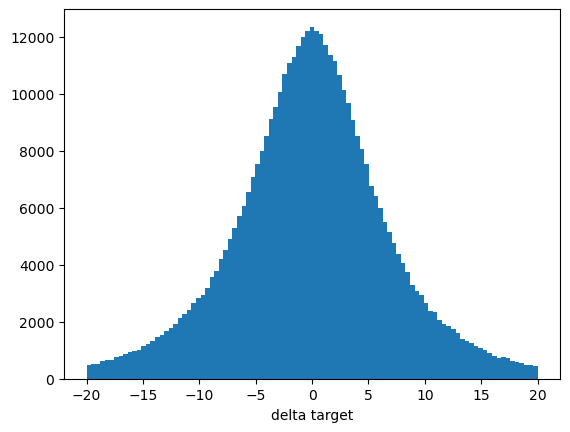

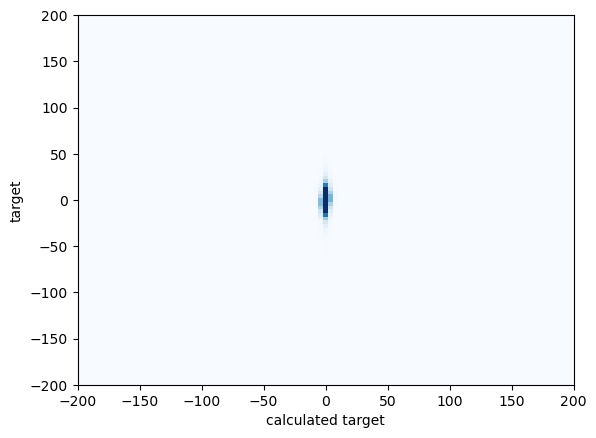

MAE: 6.16906
0.05248302876612732


In [14]:
_, ax = plt.subplots()
ax.hist(result['target'] - result['calculated_target'], bins=np.linspace(-20, 20, 100))
ax.set_xlabel('delta target')
plt.show()

_, ax = plt.subplots()
ax.hist2d(result['calculated_target'], result['target'], bins=np.linspace(-200, 200, 100), cmap='Blues', vmin=0, vmax=1e+4)
ax.set_xlabel('calculated target')
ax.set_ylabel('target')
plt.show()

mae = np.mean(abs(result['target'] - result['calculated_target']))
print(f'MAE: {mae:.5f}')

r = np.corrcoef(result['target'], result['calculated_target'])
print(r[0, 1])